In [2]:
import pandas as pd
df = pd.read_csv('hour.csv')
df.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
def is_peak(h):
    return 1 if h in [7,8,9,17,18,19] else 0

df["peak_hour"] = df["hr"].apply(is_peak)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,peak_hour
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,0


Для расширения набора признаков был добавлен новый атрибут peak_hour, отражающий принадлежность часа (hr) к «часам пик».

Поскольку на количество аренд велосипедов значительно влияет суточный ритм города, логично выделить интервалы времени, в которые наблюдается максимальная активность пользователей.

Атрибут peak_hour принимает значение:

1 - если час соответствует пиковым периодам спроса
Утренний час пик: 7:00-9:00
Вечерний час пик: 17:00–19:00

0 - в остальные часы суток

In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
df[df["hum"] == 0].shape[0], df[df["windspeed"] == 0].shape[0]


(22, 2180)

In [15]:
df_clean = df[(df["hum"] > 0.05) & (df["windspeed"] > 0.01)].copy()
df_clean.shape

(15177, 18)

Перед применением метода кластеризации K-Means был проведён анализ качества данных и выполнены шаги по очистке датасета.
Кластеризация чувствительна к дубликатам, выбросам, аномалиям и ошибкам измерения, поэтому этот этап обязателен.
Проверка наличия повторяющихся строк выполнялась с помощью:

df.duplicated().sum()

Результат показал, что дубликатов нет (0 строк), поэтому дополнительное действие не требовалось.
Были выделены признаки, которые могут содержать ошибочные значения:

hum (влажность) - в наборе присутствуют строки, где hum = 0.
Физически влажность воздуха не может быть равной нулю, поэтому эти значения считаются ошибками датчика или пропусками, записанными как 0.

windspeed (скорость ветра) - около 2180 строк имеют значение windspeed = 0.
Для этого набора данных известно, что датчик ветра часто возвращал нулевые значения вместо реальных, что приводит к существенным искажениям при кластеризации.

Проверка выполнялась кодом:

df[df["hum"] == 0].shape[0], df[df["windspeed"] == 0].shape[0]

Результаты:

hum = 0 → 22 строки

windspeed = 0 → 2180 строк

Эти значения признаны некорректными и подлежат удалению.
Для корректной дальнейшей кластеризации был сформирован очищенный датасет df_clean, в котором отсутствуют строки с ошибочным нулевым уровнем влажности и нулевой скоростью ветра.

Фильтрация выполнена так:

df_clean = df[(df["hum"] > 0.05) & (df["windspeed"] > 0.01)].copy()

Пороговые значения:

hum > 0.05 — исключены строки с невозможной нулевой влажностью

windspeed > 0.01 — удалены строки с неработающим датчиком скорости ветра

Количество строк после очистки:

(15177, 18)

Изначально датасет содержал 17379 строк → удалено 2202 строк некорректных данных.

In [16]:
df_clean.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
peak_hour     0
dtype: int64

Проверка пропусков после очистки:

df_clean.isna().sum()

Показала, что пропущенных значений нет, что подтверждает корректность фильтрации.

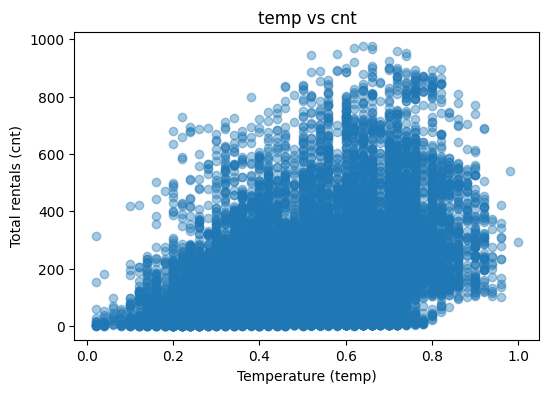

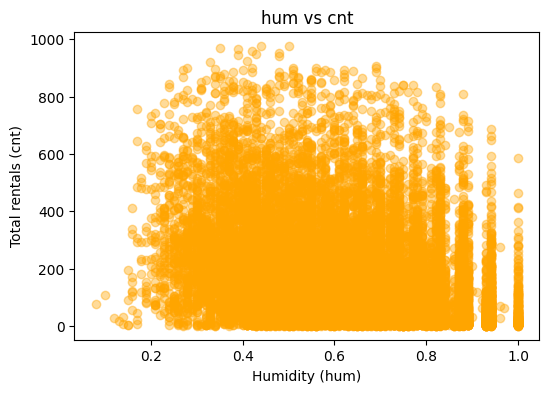

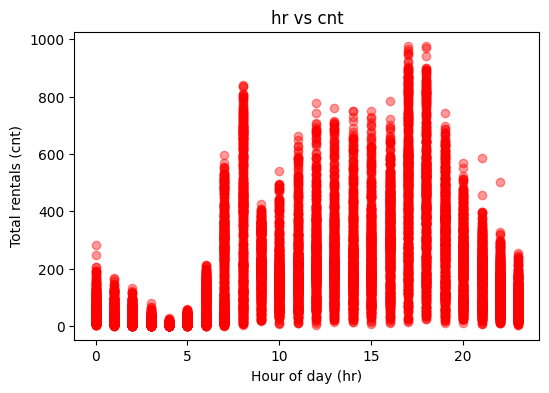

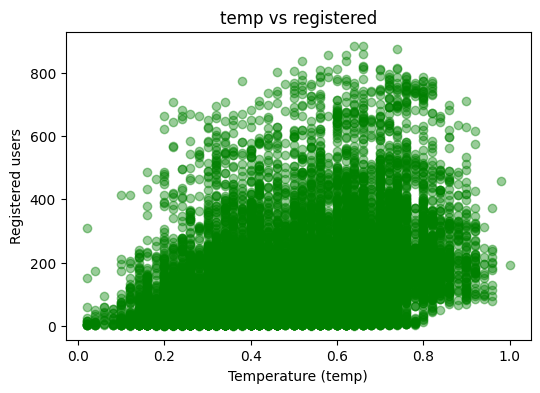

In [17]:
import matplotlib.pyplot as plt

# 1. Температура vs количество аренд
plt.figure(figsize=(6, 4))
plt.scatter(df_clean["temp"], df_clean["cnt"], alpha=0.4)
plt.xlabel("Temperature (temp)")
plt.ylabel("Total rentals (cnt)")
plt.title("temp vs cnt")
plt.show()

# 2. Влажность vs количество аренд
plt.figure(figsize=(6, 4))
plt.scatter(df_clean["hum"], df_clean["cnt"], alpha=0.4, color="orange")
plt.xlabel("Humidity (hum)")
plt.ylabel("Total rentals (cnt)")
plt.title("hum vs cnt")
plt.show()

# 3. Час суток vs количество аренд
plt.figure(figsize=(6, 4))
plt.scatter(df_clean["hr"], df_clean["cnt"], alpha=0.4, color="red")
plt.xlabel("Hour of day (hr)")
plt.ylabel("Total rentals (cnt)")
plt.title("hr vs cnt")
plt.show()

# 4. Температура vs зарегистрированные пользователи
plt.figure(figsize=(6, 4))
plt.scatter(df_clean["temp"], df_clean["registered"], alpha=0.4, color="green")
plt.xlabel("Temperature (temp)")
plt.ylabel("Registered users")
plt.title("temp vs registered")
plt.show()


1. temp vs cnt (температура → количество аренд)

График показывает явную структуру:

при низкой температуре (0-0.2) - низкий спрос (0–200);
→ кластер: холодная погода, мало аренд

при умеренной температуре (0.3-0.6) - спрос быстро растёт до 400–700 аренд;
→ кластер: комфортная погода, высокий спрос

при высокой температуре (0.7-1.0) - набор точек уплотняется на уровне 600-900 аренд;
→ кластер: жаркая погода, пик спроса

Вывод:
Температура - один из ключевых факторов поведения пользователей. Чётко выделяется минимум три естественных группы.

2. hum vs cnt (влажность → количество аренд)

На графике наблюдается:

зона низкой влажности (0.0-0.4): спрос от 200 до 900 - наиболее концентрированный кластер

при высокой влажности (0.8-1.0) спрос резко падает почти до 0

значений немного около hum=0 → явные «аномалии»

Вывод:
Высокая влажность негативно влияет на спрос - при hum → 1.0 появляются редкие выбросы с почти нулевыми арендами. Кластеризация KMeans должна хорошо разделить эту группу.

3. hr vs cnt (час суток → количество аренд)

Здесь кластеры выражены сильнее всего:

Пики спроса:

утренний пик: hr = 7-9, cnt ≈ 500–800

вечерний пик: hr = 16-19, cnt ≈ 600–900

Низкий спрос:

ночные часы: hr = 0-5, cnt < 150

поздняя ночь: hr ≈ 2–4 - кластер минимальной активности

Вывод:
График hr vs cnt демонстрирует 3 ярко выраженных естественных кластера:

Ночные часы — низкий спрос

Дневная активность — умеренный спрос

Часы пик — высокий спрос

Кластеризация должна легко выделить эти группы.

4. temp vs registered (температура → зарегистрированные пользователи)

Картина схожа с графиком temp vs cnt, но разница:

зарегистрированные (registered) растут более линейно

пик активности наступает в диапазоне temp 0.4-0.7

меньше разброса, чем casual → зарегистрированные ведут себя более предсказуемо

Вывод:
Для registered влияние температуры наиболее стабильное. Видны 3 кластера: холодно → умеренно → жарко.

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ["temp", "hum", "windspeed", "casual", "registered", "cnt", "peak_hour"]
X = df_clean[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]

array([[-1.33741764,  0.67942736, -1.20739737, -0.73519295, -1.02642707,
        -1.0564325 , -0.58746998],
       [-0.61225273,  0.73178202,  0.34417394, -0.49464616, -0.87525009,
        -0.8646888 , -0.58746998],
       [-0.71584771,  0.99355532,  0.6268795 , -0.21400824, -0.83581262,
        -0.75512098, -0.58746998],
       [-0.40506275,  0.78413668,  0.6268795 , -0.15387154, -0.67148983,
        -0.60172603, -0.58746998],
       [-0.19787277,  0.52236338,  0.76775953,  0.20694864, -0.72407312,
        -0.54694212, -0.58746998]])

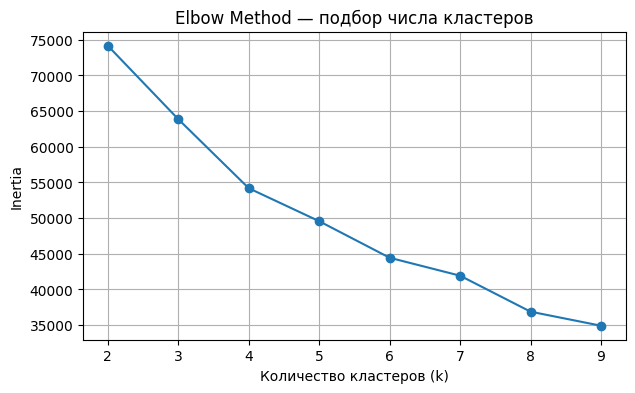

In [21]:
inertia = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method — подбор числа кластеров")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Inertia")
plt.grid()
plt.show()


In [22]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clean["cluster"] = kmeans.fit_predict(X_scaled)

df_clean["cluster"].value_counts()

cluster
1    5995
2    3768
0    2981
3    2433
Name: count, dtype: int64

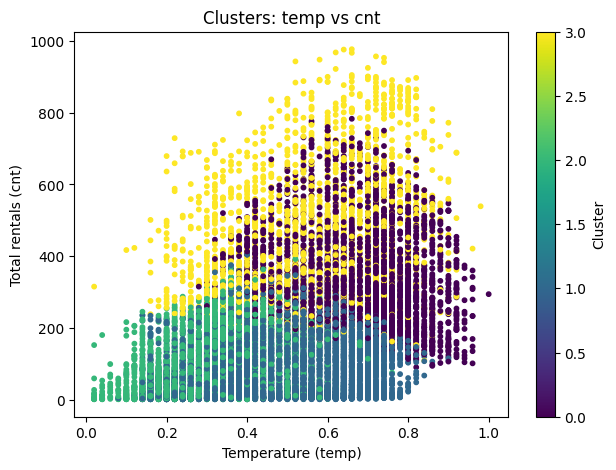

In [23]:
plt.figure(figsize=(7,5))
plt.scatter(df_clean["temp"], df_clean["cnt"], c=df_clean["cluster"], cmap="viridis", s=10)
plt.xlabel("Temperature (temp)")
plt.ylabel("Total rentals (cnt)")
plt.title("Clusters: temp vs cnt")
plt.colorbar(label="Cluster")
plt.show()


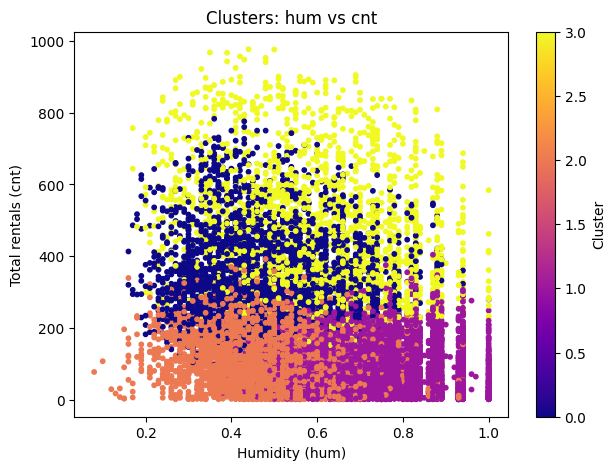

In [24]:
plt.figure(figsize=(7,5))
plt.scatter(df_clean["hum"], df_clean["cnt"], c=df_clean["cluster"], cmap="plasma", s=10)
plt.xlabel("Humidity (hum)")
plt.ylabel("Total rentals (cnt)")
plt.title("Clusters: hum vs cnt")
plt.colorbar(label="Cluster")
plt.show()


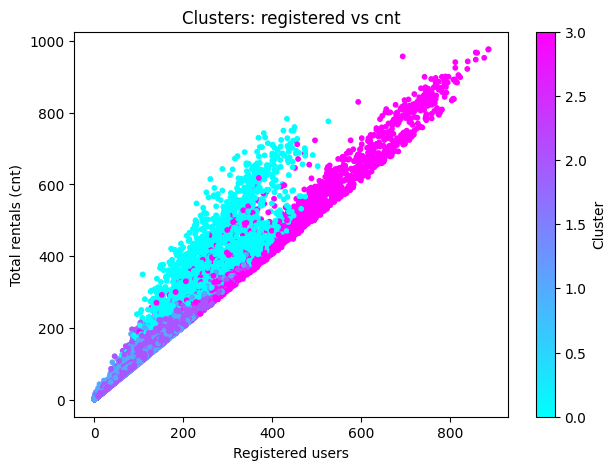

In [25]:
plt.figure(figsize=(7,5))
plt.scatter(df_clean["registered"], df_clean["cnt"], c=df_clean["cluster"], cmap="cool", s=10)
plt.xlabel("Registered users")
plt.ylabel("Total rentals (cnt)")
plt.title("Clusters: registered vs cnt")
plt.colorbar(label="Cluster")
plt.show()


Кластер 0 - низкая температура, низкий спрос

Характеристика:

Точки группируются в нижнем левом углу на графике temp vs cnt.

Температура низкая: temp < 0.4.

Спрос низкий: cnt < 200.

Зарегистрированных пользователей мало: registered < 200.

Влажность умеренная или высокая.

Вывод:
Это холодные дни и часы, в которые спрос минимален. Обычно это раннее утро, поздний вечер или холодные сезоны (зима/осень).

Кластер 1 - средняя температура и средний спрос

Характеристика:

Температура средняя: temp 0.4-0.6.

Спрос умеренный: cnt 200-500.

На графике registered vs cnt виден линейный рост, но ниже, чем у кластеров 2 и 3.

Влажность в среднем диапазоне: hum 0.4-0.7.

Вывод:
Это обычные рабочие дни со стабильной активностью. Люди берут велосипеды регулярно, но спрос не максимальный.

Кластер 2 - высокая температура и высокий спрос

Характеристика:

Температура высокая: temp 0.6-0.8.

Спрос высокий: cnt 500-800.

Количество зарегистрированных пользователей значительное: registered 300-600.

Влажность средняя или низкая.

Вывод:
Это тёплые комфортные дни, когда использование велосипедов максимально высокое, но ещё не экстремальное. Возможно, это лето/весна в дневные часы.

Кластер 3 - пиковый спрос (максимальный уровень)

Характеристика:

На графике registered vs cnt - точки кластера 3 находятся на самой верхней прямой.

Температура: от средней до высокой (temp 0.5-0.9).

Спрос максимальный: cnt 800-1000.

Зарегистрированные пользователи: registered > 600.

На графике hum vs cnt этот кластер сильно отделён - влажность чаще низкая.

Вывод:
Это пиковые часы и пиковые дни, когда систему используют максимально интенсивно.
Основная активность - зарегистрированные пользователи → поездки на работу/дом/дела.